#Real Estate Price Predictor

In [1]:
#@title Prepare Environment
%%capture
import os
import pandas
import sqlalchemy
import sqlite3
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from google.colab import userdata
import ipywidgets as widgets
from ipywidgets import GridspecLayout
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from cryptography.fernet import Fernet

def prepare():

  os.makedirs('/root/.kaggle')
  #sec = userdata.get('kagglekey')

  f = open('/root/.kaggle/kaggle.json', 'w')
  f.write('{"username":"[REDACTED]","key":"[REDACTED]"}')
  f.close()
  !chmod 600 /root/.kaggle/kaggle.json

  import kaggle
  #Download data
  !kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

  #Unzip csv file
  !unzip usa-real-estate-dataset.zip

  #Store csv data in dataframe, set zip_code to string
  data = pandas.read_csv('/content/realtor-data.zip.csv', dtype = {'zip_code': str})

  #Add rooms column
  data['rooms'] = data['bed'] + data['bath']

  #Remove null values
  data.dropna(subset = ['rooms','price','zip_code', 'house_size'], inplace = True)

  #Drop columns
  data = data.drop(columns=['brokered_by','status','bed','bath','acre_lot','street','city','state','prev_sold_date'])
  data = data[(np.abs(stats.zscore(data['price'])) < 3)]
  data = data[(np.abs(stats.zscore(data['rooms'])) < 3)]
  data = data[(np.abs(stats.zscore(data['house_size'])) < 3)]
  data = data.reset_index(drop=True)
  return data

def prepare_az():

  #Store csv data in dataframe, set zip_code to string
  data = pandas.read_csv('/content/realtor-data.zip.csv', dtype = {'zip_code': str})
  #Add rooms column
  data['rooms'] = data['bed'] + data['bath']
  #Remove null values
  data.dropna(subset = ['rooms','price','zip_code', 'house_size'], inplace = True)
  data = data[(np.abs(stats.zscore(data['price'])) < 3)]
  data = data[(np.abs(stats.zscore(data['rooms'])) < 3)]
  data = data[(np.abs(stats.zscore(data['house_size'])) < 3)]
  #Drop columns
  data = data[data['state'] == 'Arizona']
  data = data.drop(columns=['brokered_by','status','bed','bath','acre_lot','street','city','state','prev_sold_date'])
  data = data.reset_index(drop=True)
  return data

data_us = prepare()
data_az = prepare_az()

def myFunction(b):
  try:
    zipCode = grid[1, 0].value
    squareFootage = grid[2, 0].value
    numberOfRooms = grid[3, 0].value
    data_forzip = data_us[data_us['zip_code'] == zipCode]
    response = 'price'
    y = data_forzip[[response]]
    predictors = list(data_forzip.columns)
    predictors.remove(response)
    x = data_forzip[predictors]
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = .25, random_state = 0)
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_test)
    score = model.score(x_test, y_test) * 100
    #grid[1, 1].value = str(round(score, 2)) + '%'
    params = [[zipCode, squareFootage, numberOfRooms]]
    df_input = pandas.DataFrame(params, columns=['zip_code','house_size','rooms'])
    predict = model.predict(df_input)
    result = predict[0][0]
    grid[1, 1].value = 'Prediction Complete'
    grid[2, 1].value = result
    data_forzip = data_us[data_us['zip_code'] == grid[1, 0].value]
  except ValueError:
    grid[1, 1].value = 'Insufficient Data'
    grid[2, 1].value = 0


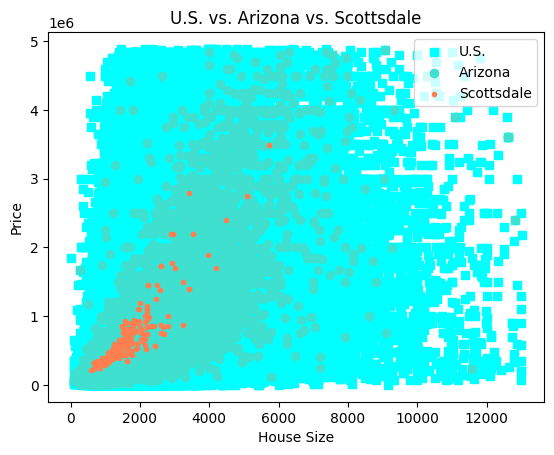

In [2]:
#@title Linear Relationships in U.S., State, and City-Level Real Estate Markets

data_forzip = data_us[data_us['zip_code'] == '85250']

#Compare prediction on Rooms
x_values_1 = data_us['house_size']
y_values_1 = data_us['price']
x_values_2 = data_az['house_size']
y_values_2 = data_az['price']
x_values_3 = data_forzip['house_size']
y_values_3 = data_forzip['price']
plt.title('U.S. vs. Arizona vs. Scottsdale')
plt.xlabel('House Size')
plt.ylabel('Price')
plt.scatter(x_values_1, y_values_1, label = 'U.S.', color='aqua', marker = ',') #2
plt.scatter(x_values_2, y_values_2, label = 'Arizona', color='turquoise', marker = 'o') #1
plt.scatter(x_values_3, y_values_3, label = 'Scottsdale', color='coral', marker = '.') #P
plt.legend()
plt.show()

In [5]:
#@title Real Estate Price Predictor
grid = GridspecLayout(5, 3, height='300px')
#grid[0, 0] = widgets.Button(description="Real Estate Price Calculator", layout=widgets.Layout(width="auto", height="auto"), button_style="success")
grid[1, 0] = widgets.Text(placeholder='Enter a U.S. Zip Code', description='Zip Code')
grid[2, 0] = widgets.IntText(placeholder='Enter Liveable Square Footage of Property', description='Square Footage')
grid[3, 0] = widgets.IntText(placeholder='Enter total # of Rooms (Bedrooms + Bathrooms)', description='# of Rooms')
#grid[1, 1] = widgets.Text(placeholder='Output will show here', description='Score')
grid[1, 1] = widgets.Text(description='Status')
grid[2, 1] = widgets.IntText(placeholder='Output will show here', description='Result')
grid[4, 0] = button = widgets.Button(
    description='Estimate Price',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Submit information for a price to be calculated.'
    )
button.on_click(myFunction)
grid

GridspecLayout(children=(Text(value='', description='Zip Code', layout=Layout(grid_area='widget001'), placehol…

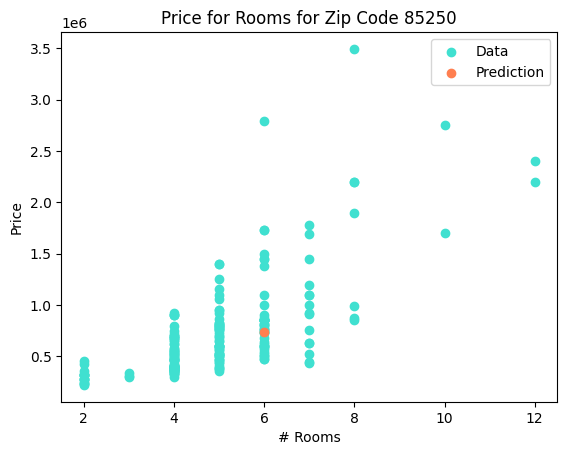

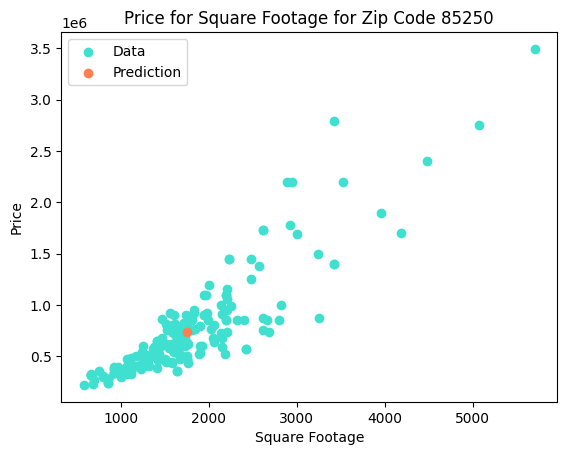

In [4]:
#@title Prediction Visualization
data_forzip = data_us[data_us['zip_code'] == grid[1, 0].value]

#Compare prediction on Rooms
x_values_1 = data_forzip['rooms']
y_values_1 = data_forzip['price']
x_values_2 = grid[3, 0].value
y_values_2 = grid[2, 1].value
plt.title('Price for Rooms for Zip Code ' + grid[1, 0].value)
plt.xlabel('# Rooms')
plt.ylabel('Price')
plt.scatter(x_values_1, y_values_1, label = 'Data', color='turquoise')
plt.scatter(x_values_2, y_values_2, label = 'Prediction', color='coral')
plt.legend()
plt.show()

#Compare prediction on Square Footage
x_values_3 = data_forzip['house_size']
y_values_3 = data_forzip['price']
x_values_4 = grid[2, 0].value
y_values_4 = grid[2, 1].value
plt.title('Price for Square Footage for Zip Code ' + grid[1, 0].value)
plt.xlabel('Square Footage')
plt.ylabel('Price')
plt.scatter(x_values_3, y_values_3, label='Data', color='turquoise')
plt.scatter(x_values_4, y_values_4, label='Prediction', color='coral')
plt.legend()
plt.show()